In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf

from src.dataset import *
from src.model import *

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Write TFRecord shards

In [2]:
# TFRWriter(image_size=256).write()

# Initialize model

In [3]:
config = {
    'local_depth': 16,
    'local_convdepth': 32,
    'local_imagesize': 256,
    'global_depth': 5,
    'global_convdepth': 64,
    'global_imagesize': 128,
    'scale': 0.25}

model = CIEXYZNet(**config)

2022-06-04 14:46:15.161235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-04 14:46:15.186589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-04 14:46:15.186865: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-04 14:46:15.187380: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with t

# Build model

In [4]:
dataloader = DataLoader('training', image_size=256)
data = dataloader.data

In [5]:
for i, batch in enumerate(data):
    logits = model(batch['sRGB_image'])
    # print(tf.reduce_max(logits))

2022-06-04 14:46:17.619478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2022-06-04 14:46:18.581810: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Filename: a1029-jn_2007_05_11__724.JPG


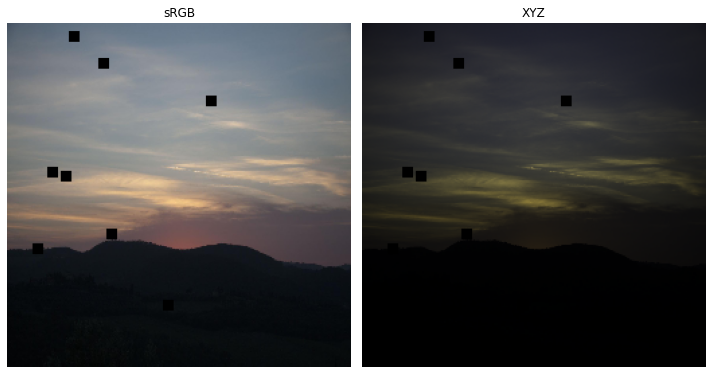

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

idx = 0
print("Filename:", batch['filename'][idx].numpy().decode())
ax[0].imshow(batch['sRGB_image'][idx])
ax[1].imshow(batch['XYZ_image'][idx])
ax[0].set_title("sRGB")
ax[1].set_title("XYZ")
ax[0].axis("off")
ax[1].axis("off")
plt.tight_layout()
plt.show()

In [7]:
model.summary()

Model: "ciexyz_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 leaky_re_lu (LeakyReLU)     multiple                  0         
                                                                 
 sRGB2XYZ_localnet (Sequenti  (None, 256, 256, 3)      131235    
 al)                                                             
                                                                 
 XYZ2sRGB_localnet (Sequenti  (None, 256, 256, 3)      131235    
 al)                                                             
                                                                 
 sRGB2XYZ_globalnet (Sequent  (None, 18)               1217554   
 ial)                                                            
                                                                 
 XYZ2sRGB_globalnet (Sequent  (None, 18)               1217554   
 ial)                                                   

In [8]:
model.srgb2xyz_localnet.summary()

Model: "sRGB2XYZ_localnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_0 (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 conv_1 (Conv2D)             (None, 256, 256, 32)      9248      
                                                                 
 conv_2 (Conv2D)             (None, 256, 256, 32)      9248      
                                                                 
 conv_3 (Conv2D)             (None, 256, 256, 32)      9248      
                                                                 
 conv_4 (Conv2D)             (None, 256, 256, 32)      9248      
                                                                 
 conv_5 (Conv2D)             (None, 256, 256, 32)      9248      
                                                                 
 conv_6 (Conv2D)             (None, 256, 256, 32)

In [9]:
model.srgb2xyz_globalnet.summary()

Model: "sRGB2XYZ_globalnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 128, 128, 3)       0         
                                                                 
 conv_0 (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 maxpool_0 (MaxPooling2D)    (None, 64, 64, 64)        0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 64, 64)        36928     
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 32, 32, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        36928     
                                                                 
 maxpool_2 (MaxPooling2D)    (None, 16, 16, 64) 